# Predicting House Value in Boston

## 1. Introduction

## 2. Exploratory Data Analysis

In [1]:
options(repr.plot.width=8, repr.plot.height=6)
library(broom)
library(tidyverse)
library(infer)
library(repr)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(AER)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-4

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following objects are masked from ‘package:faraway’:

    logit, vif


The following object is masked from ‘package:dplyr’:

    recode



Reading dataset and assigning names to each column

In [2]:
boston_data <-read_tsv("dataset.txt",
                      col_names=FALSE) %>%
    separate(col=X1,
             into=c("CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","LSTAT","MEDV"),
             sep="  ") %>%
    separate(col=PTRATIO,
             into=c("PTRATIO","B"),
             sep=" ") %>%
    mutate_if(is.character,as.numeric) 

head(boston_data)

Rows: 506 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 13 pieces. Additional pieces discarded in 24 rows [103, 156, 157, 417, 420, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 437, 439, 446, 451, 455, ...].”
Warning message:
“Expected 13 pieces. Missing pieces filled with `NA` in 42 rows [9, 24, 32, 58, 142, 143, 144, 146, 147, 152, 159, 160, 210, 259, 260, 352, 353, 354, 355, 356, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 59 rows [9, 24, 32, 103, 142, 143, 144, 146, 147, 152, 156, 157, 210, 368, 374, 375, 380, 383, 384, 387, ...].”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning mess

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


The dataset has missing entries (NA) which we will remove from the dataset

In [3]:
boston_data <- na.omit(boston_data)

## 3. Method

Splitting dataset into training and testing datasets (70/30 split)

In [4]:
# Split data into training and test sets
set.seed(123)

boston_data$ID <- rownames(boston_data)

training_boston <- sample_n(boston_data, size = nrow(boston_data) * 0.70,
  replace = FALSE
)

testing_boston <- anti_join(boston_data,
  training_boston,
  by = "ID"
)

# Remove variable "ID"
training_boston <- training_boston  %>% select(-ID)
testing_boston <- testing_boston  %>% select(-ID)

### Full OLS

Using `lm` to build a full regression model (including all explanatory variables)

In [5]:
boston_OLS <- lm(MEDV ~ ., data = training_boston)

Using OLS model to get fitted values on test set

In [6]:
boston_test_OLS <- predict(boston_OLS, testing_boston)

Computing out-of-sample error (RMSE)

In [7]:
boston_OLS_MSE <- tibble(
    Model = "OLS Full Regression",
    R_MSE = rmse(
      preds = boston_test_OLS,
      actuals = testing_boston$MEDV)
    )

boston_OLS_MSE

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,4.648719


### Forward/Backward Selection

### Variable Selection using LASSO 

Building matrix and vector using training set (training_boston) as it is required by `glmnet`

In [8]:
boston_X_train <- training_boston %>% select(-MEDV) %>% as.matrix()
boston_Y_train <- training_boston %>% select(MEDV) %>% as.matrix()

boston_X_test <- testing_boston %>% select(-MEDV) %>% as.matrix()
boston_Y_test <- testing_boston %>% select(MEDV) %>% as.matrix()

Using `cv.glmnet` to do cross validation to find the best lambda ($\lambda$)

In [17]:
lasso_cv <-
    cv.glmnet(boston_X_train, 
              boston_Y_train, 
              alpha = 1)

lasso_cv


Call:  cv.glmnet(x = boston_X_train, y = boston_Y_train, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.0226    62   18.19 3.077      13
1se 0.9331    22   21.04 3.425       4

Plot: CV Mean square error (MSE) over a range of $\log(\lambda)$ values

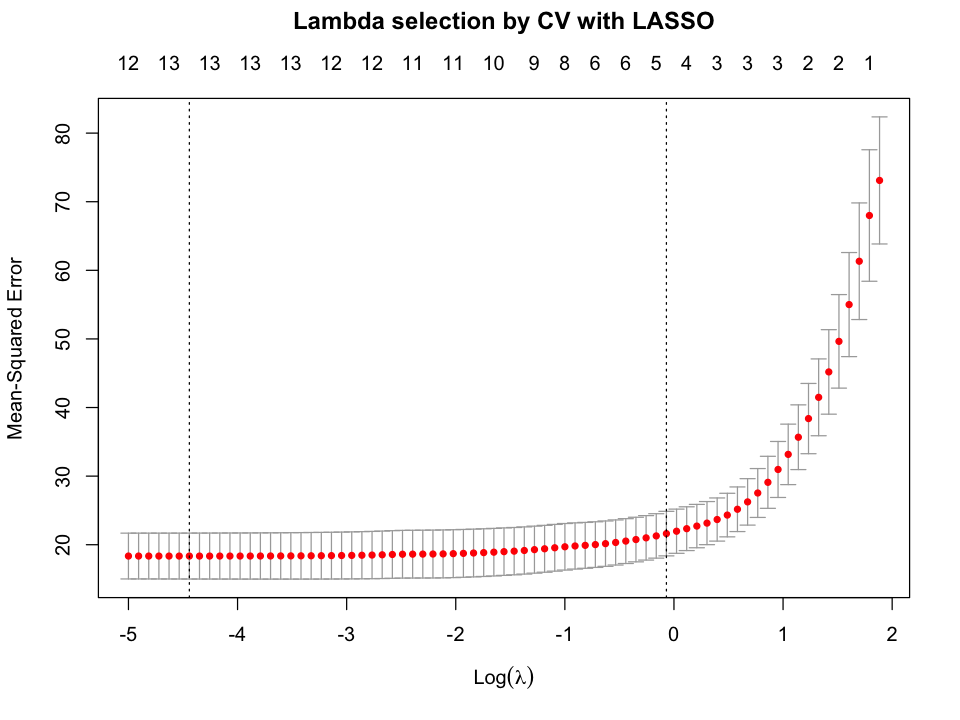

In [18]:
plot(lasso_model, main = "Lambda selection by CV with LASSO\n\n")

Obtaining $\lambda$ that minimizes MSE ($\lambda_{min}$) and the largest $\lambda$ such that it is within one standard error of the minimum MSE ($\lambda_{1se}$).

In [22]:
lambda_min <- lasso_model$lambda.min
lambda_1se <- lasso_model$lambda.1se

Plot: Estimated regression coefficients over the $\lambda$-grid where the vertical red line is $\log(\lambda_{min})$ and the blue line is $\log(\lambda_{1se})$

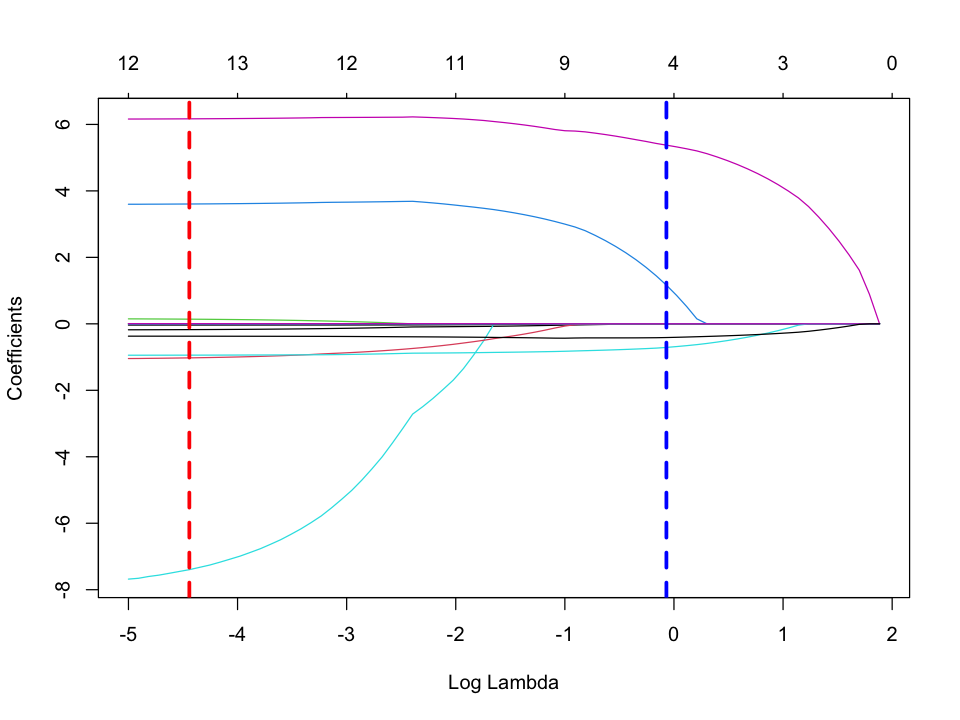

In [12]:
plot(lasso_model$glmnet.fit, "lambda")
abline(v = log(lambda_min), col = "red", lwd = 3, lty = 2)
abline(v = log(lambda_1se), col = "blue", lwd = 3, lty = 2)

Fitting lasso model using $\lambda_{min}$ and $\lambda_{1se}$

In [23]:
# Using lambda.min
boston_LASSO_min <- glmnet(
  x = boston_X_train, y = boston_Y_train,
  alpha = 1,
  lambda = lambda_min
)

boston_LASSO_1se <- glmnet(
  x = boston_X_train, y = boston_Y_train,
  alpha = 1,
  lambda = lambda_1se
)

Using `predict` to get fitted values of test set using our Lasso models

In [24]:
boston_test_LASSO_min <- predict(boston_LASSO_min,
  newx = boston_X_test)

boston_test_LASSO_1se <- predict(boston_LASSO_1se,
  newx = boston_X_test)

Calculating out-of-sample error (RMSE)

In [26]:
boston_LASSO_MSE <- rbind(boston_OLS_MSE,
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
      preds = boston_test_LASSO_min,
      actuals = testing_boston$MEDV)
    ), 
    tibble(
    Model = "LASSO Regression with 1 SE of minimum MSE",
    R_MSE = rmse(
      preds = boston_test_LASSO_1se,
      actuals = testing_boston$MEDV)
    )
)
boston_LASSO_MSE

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,4.648719
LASSO Regression with minimum MSE,4.660902
LASSO Regression with 1 SE of minimum MSE,5.115156
